In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
tf.__version__

'2.9.1'

In [3]:
keras.__version__

'2.9.0'

# Perceptron

El "perceptrón" es una de las arquitecturas de RNA más sencillas, creada en 1957 por Frank Rosenblatt. Se basa en una neurona artificial ligeramente diferente llamada Unidad Lógica Umbral (ULU).

Las entradas y salidas son números (en lugar de activadores binarios) y cada conexión de entrada está asociada a un peso.

La ULU cálcula una suma ponderada de sus entrada ($ x = w_1 x_1 + w_2 x_2 + ... + w_n x_n = X^T W $) y luego aplica una función escalonada a esa suma para producir el resultado (output): $ h_w (X) = step(z) $, donde $ z = X^T W $ 

<img src="https://quantstartmedia.s3.amazonaws.com/images/article-images/articles/introduction-to-artificial-neural-networks-and-the-perceptron/perceptron.png"  width="500" height="500">

La función escalonada que se utiliza frecuentemente en los perceptrones es la función escalonada Heaviside

$ Heavise(z) = $ { $ 0 $ si $ z < 0 $ ; $ 1 $ si $ z \geq 0 $

Un perceptrón consta de una sola capa ULU. Cuando todas las neuronas de una capa estan conectadas a todas las neuronas de la capa anterior (neuronas de entrada), estamos ante una capa completamente conectada o densa.

Se suele añadir una capa de sesgo adicional ($ x_0 = 1 $): representada por una neurona de sesgo que produce 1 todo el tiempo.

La siguiente imagen representa un perceptróm con dos entradas y tres salidas, este perceptrón puede clasificar simultaneamente tres clases binarias diferentes, siendo un clasificador multisalida.

<img src="https://www.danli.org/2021/06/21/hands-on-machine-learning-keras/chapters/10/10.5.png"  width="500" height="500">

Se puede cálcular con eficiencia la salida de una capa de neurona para varias instancias:

$ h_{W, b} (X) = \phi (XW + b) $

En la ecuación tenemos:

- $X$: Matriz de características de entrada. Una fila por instancia y una columna por característica.
- $W$: Matriz de pesos de conexión, excepto la neurona de sesgo. Tiene una fila por neurona de entrada y una columna por neurona artificial en la capa.
- $b$: Vector de sesgo, que contiene todos los pesos de conexión entre la neurona de sesgo y las neuronas artificiales.
- $\phi$: Función de activación: cuando las neuronas artificiales son ULU, es una función escalonada pero hay otras.

## ¿Cómo se entrena un perceptrón?

El algoritmo de entrenamiento del perceptrón se basa en la regla de Hebb de su libro de 1949, Organización de la Conducta (Debate), donde se sugiere que cuando una neurona biologica activa a otra, con frecuencia la conexión entre estas dos se fortalece. 

Los perceptrones se entrenan con una variación de esta regla que tiene en cuenta el error cometido por la red cuando hace una predicción. El perceptrón recibe las instancias de entrenamiento y realiza sus predicciones para cada instancia, Por cada neurona de salida que produce una predicción erronea, refueza los pesos de conexión a partir de las entradas que habrían contribuido a la predicción correcta. La regla de aprendizaje es la siguiente:

$ w_{i,j}^{Siguiente} =  w_{i,j} + \eta(y_j - \hat{y}_j) x_i $

- $w_{i, j}$: El peso de conexión entre la i-esima neurona de entrada y la j-esima neurona de salida.
- $x_i$: El valor de la i-esima neurona de salida para la instancia de entrenamiento actual.
- $\hat{y}_j$: El valor de salida de la j-esima neurona para la instancia de entrenamiento actual.
- $y_i$: El valor objetivo de la j-esima neurona para la instancia de entrenamiento actual.
- $\eta$: Tasa de aprendizaje.

El límite de decisión de cada neurona es lineal, así que los perceptrones son incapaces de aprender patrones complejos. Sin embargo, las instancias de entrenamiento son separables linealmente, lo que permite converger a uan solución.

La instancia en Scikit-Learn orfdere una solución para el perceptrón.

In [18]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

In [20]:
iris = load_iris()
X = iris.data[:, (2,3)] # longitud de pétalo, anchura del pétalo
y = (iris.target == 0).astype(np.int32) # ¿Iris setosa?

In [21]:
clf = Perceptron()
clf.fit(X, y)

Perceptron()

In [24]:
y_pred = clf.predict([[2, 0.5]])
y_pred

array([0], dtype=int32)

Los perceptrones no permiten obtener probabilidades, sino que hacen predicciones basándose en un umbral duro, por eso es deseable una regresión logistica.

# Perceptrón Multicapa (PMC) y la retropropagación

Un PMC consta de una capa de entrada (transito), una o varias capas de ULU (llamada capas ocultas) y una última capa de ULU (capa de salida).Las capas cercanas a la entrada suelen llamarse "capas inferiores", y las próximas a la salida "capas superiores". Cada capa, excepto la de salida, incluye una neurona de sesgo y está completamente conectada a la siguiente capa.

<img src="https://www.danli.org/2021/06/21/hands-on-machine-learning-keras/chapters/10/10.9.png"  width="500" height="500">

Cuando una RNA contiene una pila profunda de capas ocultas, se habla de una Red Neuronal Profunda (RNP). En el campo del Deep Learning se estudia RNA y, en general, modelos que contienen pilas profundas de cálculos. 

## Retropropagación

Es un método de entrenamiento de los PMC, propuesto en 1986, que introduce la retropropagación, similar a las técnicas de gradiente descendiente: en solo dos pasos (hacía delante y atrás) la red puede cálcular el gradiente de error de la red respecto a cada parámetro del modelo. En otras palabras, puede averiguar cómo habría que ajustar cada peso de conexión y cada término de sesgo para reducir el error.

# Implementación de PMC con Keras

## Extracción de datos Fashion MNIST

In [5]:
# Conjunto de datos similar a MNIST, con 70.000 imagenes en escala de grises de 28x28 pixels y 10 clases de articulos de moda
fashion_mnist = keras.datasets.fashion_mnist

In [9]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [10]:
X_train_full.shape

(60000, 28, 28)

In [11]:
X_train_full.dtype

dtype('uint8')

In [12]:
# Creando conjunto de validación
# Se escala la densidad de pixeles hasta el rango 0-1, dividiendo entre 255
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [13]:
# Se asocia las etiquetas númericas con nombres representativos
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [15]:
class_names[y_train[0]]

'Coat'

## Creación del modelo con la API Secuencial

Crea el modelo Sequential. es el tipo más sencillo de modelos en Keras para RNA. 

Consta de una sola única pila de capas conectadas secuencialmente.

model = keras.models.Sequential()

Se construye la primera capa y se añade al modelo. Capa Flatten convierte la entrada de imagen en una matriz 1D. 

Esta capa no tiene parametros, solo existe para el preprocesamiento.

Dado que es la primera capa, se debe especificar el input_shape, que da la forma de la instancia.

In [ ]:
model.add(keras.layers.Flatten(input_shape = [28, 28]))

Se añade una capa Dense oculta con 300 neuronas, que utiliza la función de activación ReLU. 

Cada capa Dense administra su propia matriz de pesos, que contiene los pesos de conexión entre las neuronas y sus salidas.

También gestiona un vector de términos de sesgo (uno por neurona), cuando recibe datos de entrada, computa la siguiente ecuación:

$ h_{W,b}(X) = \Phi(X W + b) $ 

In [ ]:
model.add(keras.layers.Dense(300, activation = 'relu'))

Se añade una segudna capa Dense oculta con 100 neuronas, también con la función de activación ReLU.

In [ ]:
model.add(keras.layers.Dense(100, activation = 'relu'))

Por último, añadimos una capa de salida Dense con 10 neurona (una por clase), con la función de activación softmax (dado que las clases son exclusivas).

In [ ]:
model.add(keras.layers.Dense(10, activation = 'softmax'))

### Otra forma de implementar el modelo

In [28]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(300, activation = 'relu'),
    keras.layers.Dense(100, activation = 'relu'),
    keras.layers.Dense(10, activation = 'softmax')
])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Las capas Dense tienen con frecuencia muchos parámetros. Por ejemplo, la primera capa oculta tiene 784x300 pesos de conexión, más 300 términos de sesgo, lo que da la suma de 235.500 parámetros. Dando al modelo mucha flexibilidad para ajustar los datos de entrenamiento, pero también significa que está en riesgo de sobreajuste, sobre todo cuando no se cuenta con muchos datos de entrenamiento

Lista de capas del modelo para buscar una capa por indice o b

In [31]:
model.layers

In [ ]:
hidden1 = model.layers[1]
hidden1.name

'dense_3'

In [37]:
model.get_layer('dense_3') is hidden1

True

Se puede acceder a todos los parámetros de una capa:

In [38]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.01722668,  0.03618187, -0.02348909, ..., -0.03296559,
        -0.01114808,  0.0700599 ],
       [ 0.02781989,  0.02758691, -0.03135449, ..., -0.01861966,
        -0.03237749,  0.0237383 ],
       [ 0.06967348, -0.04436409, -0.01525133, ..., -0.04863381,
         0.05229123, -0.03187001],
       ...,
       [-0.02644977,  0.01671094,  0.04635596, ...,  0.01475454,
         0.06725679,  0.06777671],
       [-0.00200869, -0.03166008,  0.05024006, ...,  0.06084898,
        -0.01336817, -0.06971929],
       [-0.02432529, -0.07053582,  0.02338087, ...,  0.006532  ,
         0.02069069,  0.03839889]], dtype=float32)

In [39]:
weights.shape

(784, 300)

In [40]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [41]:
biases.shape

(300,)

Los pesos de la capa Dense se han inizializado aleatoriamente y los sesgos se han inizializados en cero. Si se desea iniciar con un método diferente, se puede configurar con _kernel_initializer_ o _bias_initializer_ al crear la capa.

## Compilación del modelo

Tras crear el modelo, hay que llamar a su método compile() para especificar la función de pérdida y el optimizador que se utilizarán.

- https://keras.io/losses
- https://keras.io/optimizers
- https://keras.io/metrics

In [42]:
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = "sgd",
              metrics = ["accuracy"])

La función de perdirdida "sparse_categorical_crossentropy" se utiliza en clasificación multietiqueta.

Para clasifición binaria se utiliza la función de activación "sigmoid" en la capa de salida en lugar de una función "softmax", y utilizariamos la perdida "binary_crossentropy".

## Entrenamiento y evaluación

In [44]:
history = model.fit(X_train, y_train, 
                    epochs = 30, 
                    validation_data = (X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 5s 2ms/step - loss: 0.7221 - accuracy: 0.7682 - val_loss: 0.5465 - val_accuracy: 0.8032
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4844 - accuracy: 0.8321 - val_loss: 0.4431 - val_accuracy: 0.8486
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4417 - accuracy: 0.8449 - val_loss: 0.4443 - val_accuracy: 0.8450
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4116 - accuracy: 0.8539 - val_loss: 0.4303 - val_accuracy: 0.8524
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3923 - accuracy: 0.8630 - val_loss: 0.3964 - val_accuracy: 0.8590
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3766 - accuracy: 0.8677 - val_loss: 0.3770 - val_accuracy: 0.8690
Epoch 7/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3635 - accuracy: 0.8714 - val_loss: 0.3710 - val_accuracy:

El método fit() devuelve un objeto History que contiene los parámetros de entrenamiento (history.params), la lista de repeticiones por las que ha pasado (history.epoch) y, lo que más importante, un diccionario (history.history) que contiene la perdida y las métricas adicionales.

Se puede utilizar el diccionario para crear un gráfico con las curvas de aprendizaje.

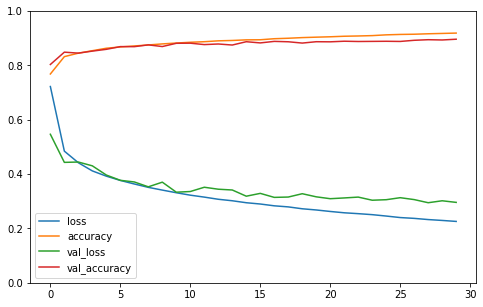

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.gca().set_ylim(0, 1)
plt.show()

Tanto la exactitud del entrenamiento como de validación aumentan continuamente, mientras que la pérdida de entrenamiento y la validacióndisminuyen.

Las curvas de validación y entrenamiento son muy cercanas lo que significa que no hay demasiado sobreajuste.

Es común que el rendimiento de la curva de entrenamiento supere a la de validación, como suele ocurrir cuando se entrena el tiempo suficiente.

Se peude saber que el modelo aún no converge dado que la pérdida de validación sigue bajando, por lo que es probable que se deba seguir entrenando.

### Ajuste de parámetros

Si los resultados no son favorables, se debe ajustar: 
- la tasa de aprensizaje
- otro optimizador
- otros números de capas
- neuronas por número de capas
- tipos de funciones de activación

## Evaluar la generalización

Se evalua el desempeño con los datos de testing

In [46]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 62.5471 - accuracy: 0.8525


[62.54712677001953, 0.8525000214576721]

## Predicciones

In [47]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 86ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Se calcula, para cada instancia, una probabilidad por clase, desde la 0 a la 9. La primera imagen se estima que es "Ankle boot" con 100% de probabilidad.

In [54]:
y_pred = np.argmax(y_proba, axis=1)
y_pred

array([9, 2, 1])

In [55]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')